<a href="https://colab.research.google.com/github/susalihh/sinir-aglari-ile-zaman-serisi-analizi-ve-tahmini/blob/main/yz_proje.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#veri hazırlama
import warnings

import numpy as np
from numpy import array
import pandas as pd
from pandas import concat
import math
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from statsmodels.tsa.arima.model import ARIMA
from sklearn.model_selection import ParameterGrid

pd.plotting.register_matplotlib_converters()

warnings.filterwarnings("ignore")

import logging
logger = logging.getLogger()
logger.setLevel(logging.CRITICAL)

def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [ ]:
!pip install pmdarima

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


Zaman serisi analizi

Mevsimsellik analizi

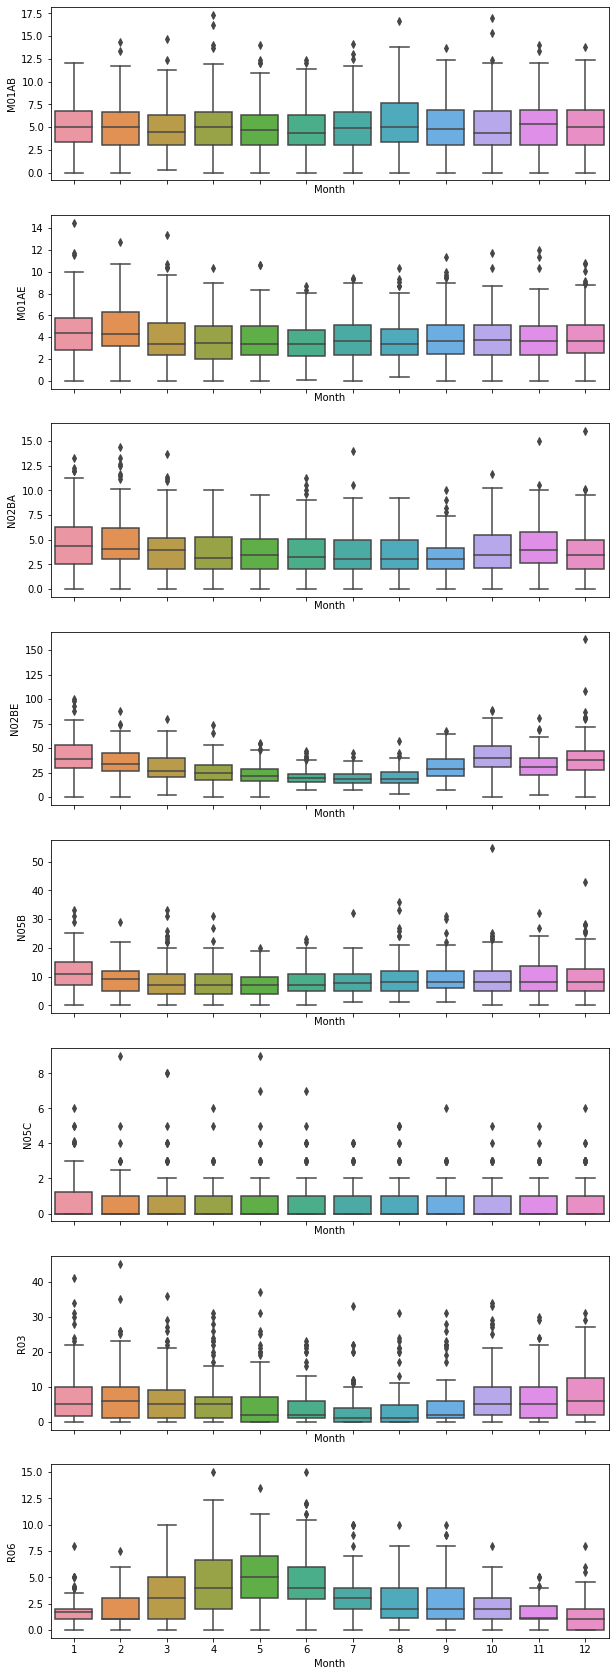

In [ ]:
import seaborn as sns
dfatc_daily = pd.read_csv('./salesdaily.csv')
fig, axes = plt.subplots(8, 1, figsize=(10, 30), sharex=True)
for name, ax in zip(['M01AB','M01AE','N02BA','N02BE', 'N05B','N05C','R03','R06'], axes):
    sns.boxplot(data=dfatc_daily, x='Month', y=name, ax=ax)

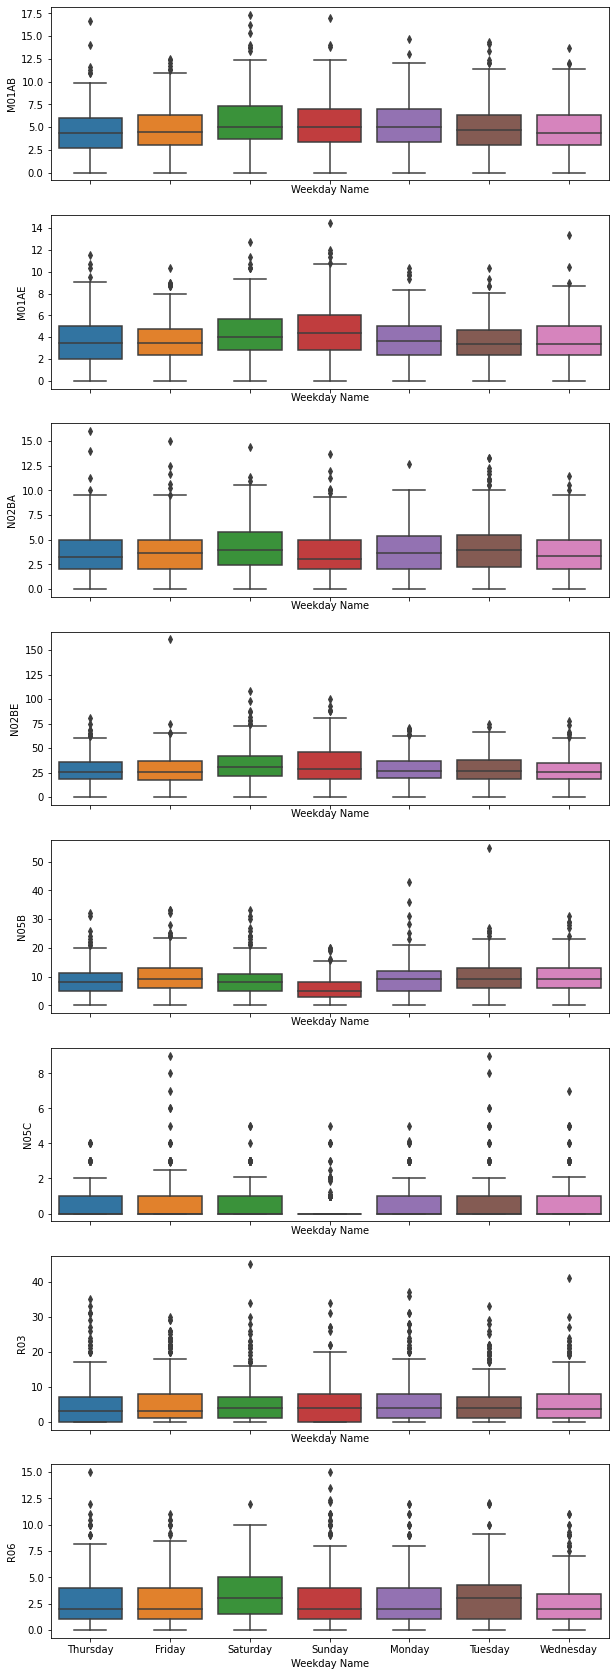

In [ ]:
fig, axes = plt.subplots(8, 1, figsize=(10, 30), sharex=True)
for name, ax in zip(['M01AB','M01AE','N02BA','N02BE', 'N05B','N05C','R03','R06'], axes):
    sns.boxplot(data=dfatc_daily, x='Weekday Name', y=name, ax=ax)

Yukarıda, zayıf mevsimselliği araştırmak amacıyla haftalık ölçekte kutu grafikleri gösterilmektedir. Bazı haftalık mevsimsellik görülebilir.

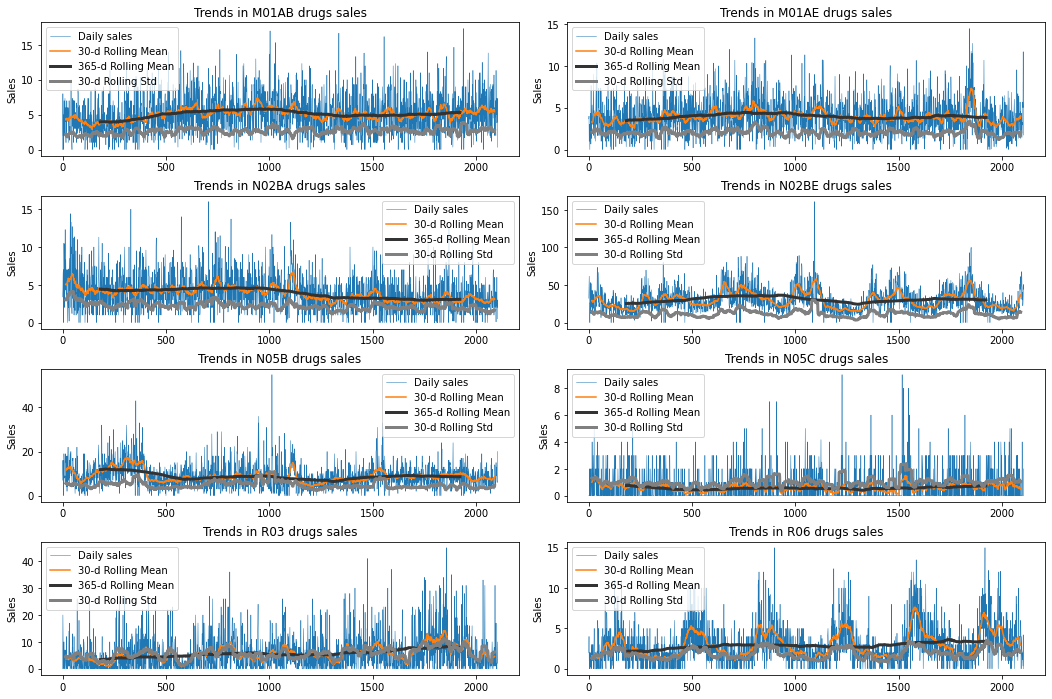

In [ ]:
dfatc_daily=pd.read_csv('./salesdaily.csv')
cols_plot = ['M01AB','M01AE','N02BA','N02BE', 'N05B','N05C','R03','R06']
dfatc_365d = dfatc_daily[cols_plot].rolling(window=365, center=True).mean()
dfatc_30d = dfatc_daily[cols_plot].rolling(30, center=True).mean()
dfatc_std = dfatc_daily[cols_plot].rolling(30, center=True).std()
subplotindex=0
numrows=4
numcols=2
fig, ax = plt.subplots(numrows, numcols, figsize=(18, 12))
plt.subplots_adjust(wspace=0.1, hspace=0.3)

for x in cols_plot:
    rowindex=math.floor(subplotindex/numcols)
    colindex=subplotindex-(rowindex*numcols)
    ax[rowindex,colindex].plot(dfatc_daily.loc[:,x], linewidth=0.5, label='Daily sales')
    ax[rowindex,colindex].plot(dfatc_30d.loc[:,x], label='30-d Rolling Mean')
    ax[rowindex,colindex].plot(dfatc_365d.loc[:,x], color='0.2', linewidth=3, label='365-d Rolling Mean')
    ax[rowindex,colindex].plot(dfatc_std.loc[:,x], color='0.5', linewidth=3, label='30-d Rolling Std')
    ax[rowindex,colindex].set_ylabel('Sales')
    ax[rowindex,colindex].legend()
    ax[rowindex,colindex].set_title('Trends in '+x+' drugs sales');   
    subplotindex=subplotindex+1
plt.show()

Yuvarlanan pencere işlemleri.
Yukarıdaki analiz, satış verilerinin 30 günlük ve 365 günlük yuvarlanan ortalamasını ve 30 günlük yuvarlanan standart sapmasını gösterir.

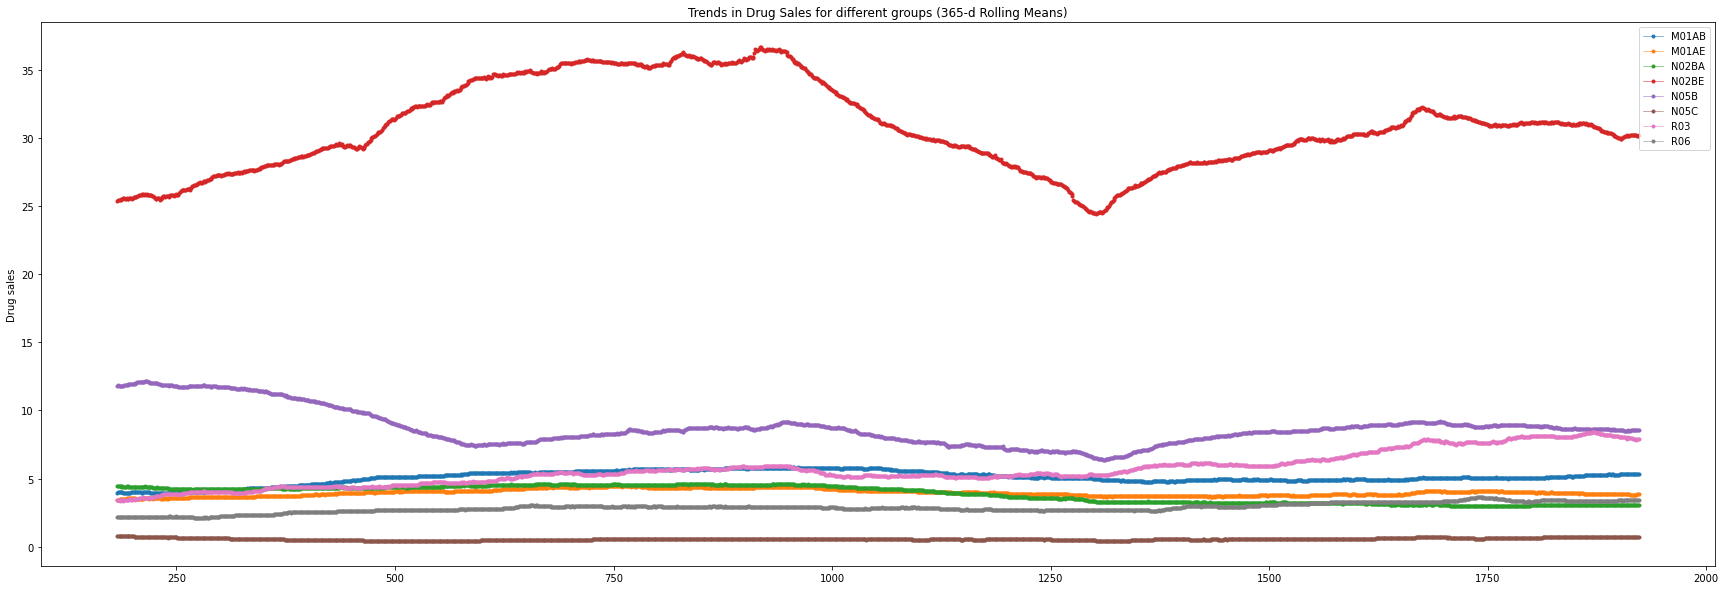

In [ ]:
fig, ax = plt.subplots(figsize=(30, 10))
for nm in cols_plot:
    ax.plot(dfatc_365d[nm], label=nm, marker='.', linestyle='-', linewidth=0.5)
    ax.legend()
    ax.set_ylabel('Drug sales')
    ax.set_title('Trends in Drug Sales for different groups (365-d Rolling Means)');

Yukarıdaki grafik, bu kategorilerin her biri için 365-d yuvarlanma araçlarıyla temsil edilen her bir ilaç kategorisine ilişkin eğilimleri göstermektedir.

Trendler ve mevsimsellik, 30d yuvarlanma araçlarına dayalı olarak zaman serisi ayrıştırma görünümünde keşfedilebilir.

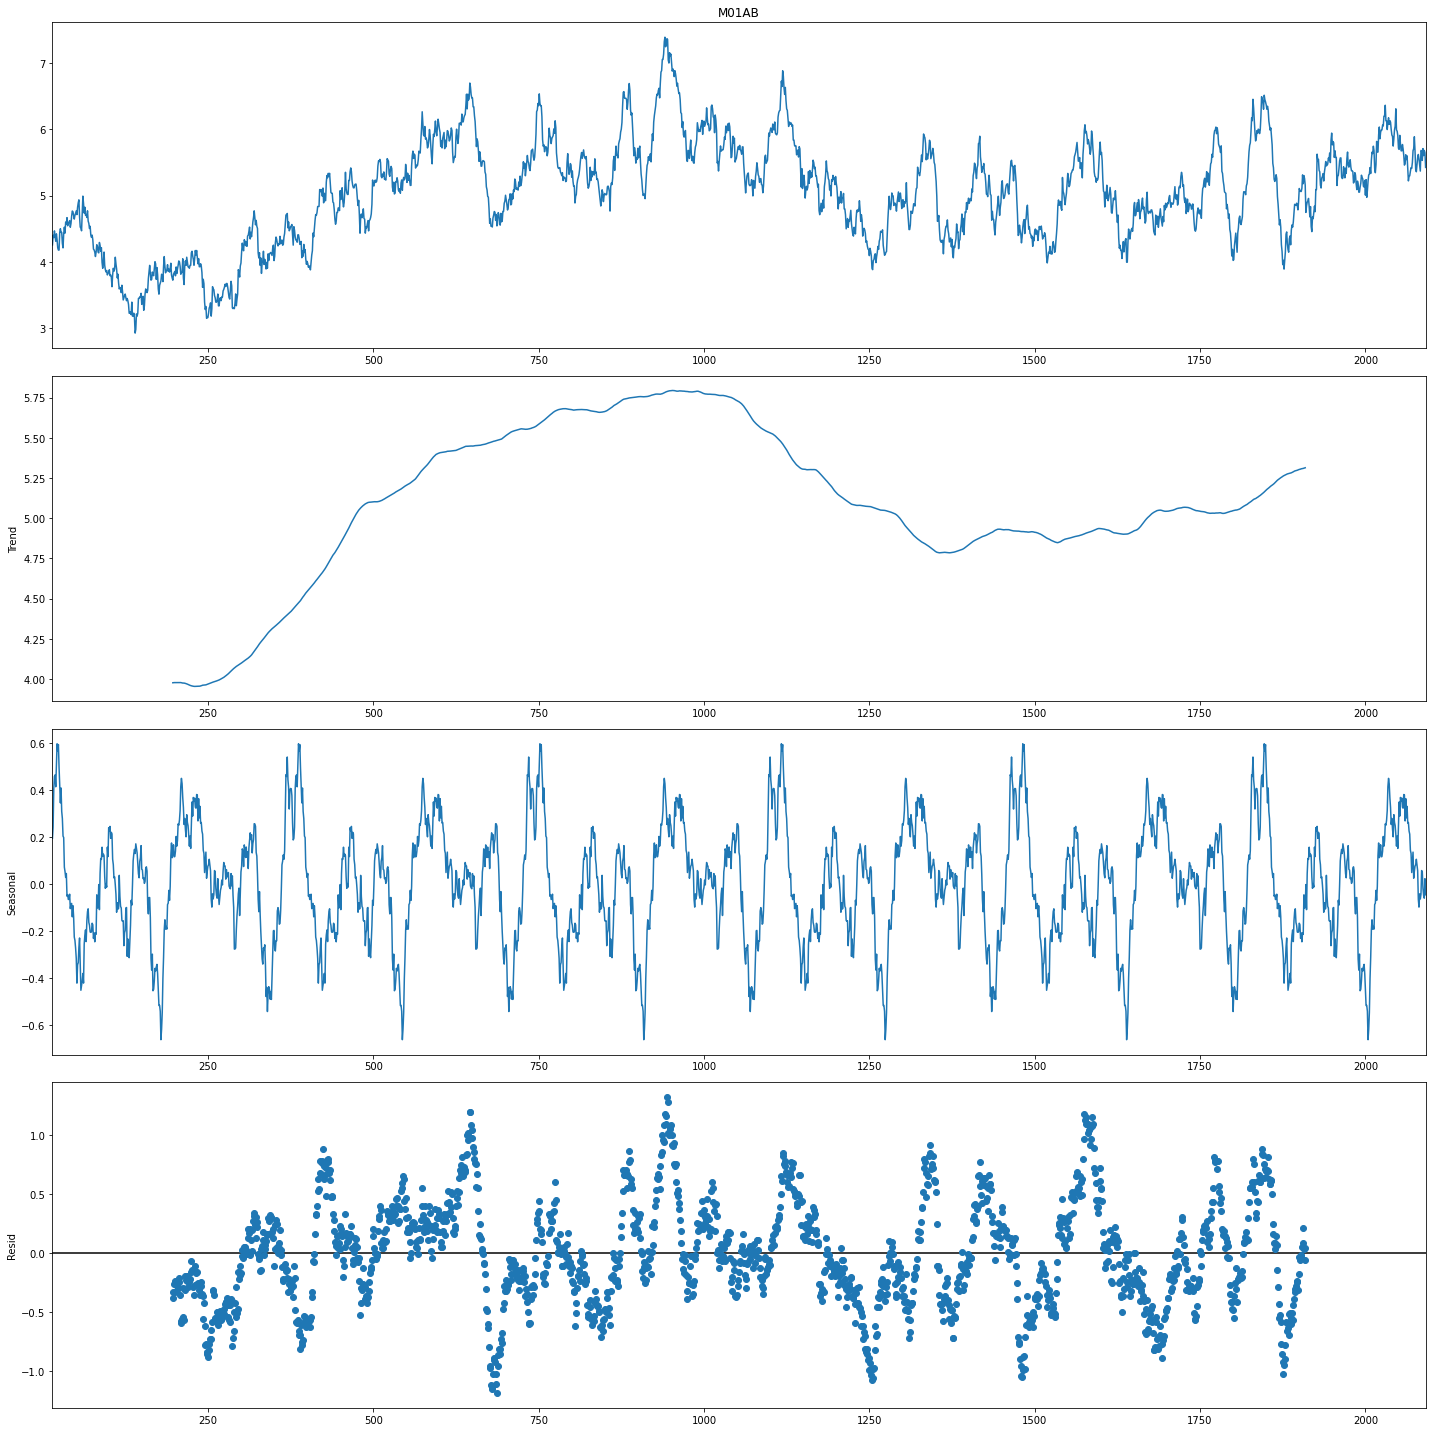

In [ ]:
from statsmodels.tsa.seasonal import seasonal_decompose
result = seasonal_decompose(dfatc_daily['M01AB'].rolling(30, center=True).mean().dropna(), period=365, filt=None)
plt.rcParams["figure.figsize"] = (20,20)
result.plot()
plt.show()

Mevsimsel_decompose işlevi.
Bu, özellikle ayrıştırılmış verilere dayalı olarak verilerdeki artıkların alımını belirlerken kullanışlıdır. Bu alımın hacmi, zaman serisinin tahmin edilebilirliğini ifade eder - artıklar ne kadar yüksekse, tahmin edilebilirlik o kadar düşük olur.

In [ ]:
df = pd.read_csv('./salesweekly.csv')
for x in ['M01AB','M01AE','N02BA','N02BE','N05B','N05C','R03','R06']:
    result = seasonal_decompose(df[x], period=52, model='additive')
    dfs = pd.concat([result.trend, result.seasonal, result.resid, result.observed], axis=1)
    dfs.columns = ['trend', 'seasonal', 'residuals', 'observed']
    dfs=dfs.dropna()
    res=dfs['residuals'].values
    obs=dfs['observed'].values
    resmean=np.mean(np.abs(res))
    obsmean=np.mean(np.abs(obs))
    perc=resmean*100/obsmean
    print(x+' RESMEAN:'+str(resmean)+', OBSMEAN:'+str(obsmean)+', PERC:'+str(perc)+'%')

M01AB RESMEAN:5.26715996284115, OBSMEAN:35.59490833332001, PERC:14.797509558159527%
M01AE RESMEAN:4.319542609675869, OBSMEAN:28.00801458336, PERC:15.422523423856601%
N02BA RESMEAN:3.9228389592521657, OBSMEAN:27.083016, PERC:14.484498178682042%
N02BE RESMEAN:29.534357236963668, OBSMEAN:217.6597028336, PERC:13.569051529737028%
N05B RESMEAN:12.94840305932125, OBSMEAN:61.96614999972, PERC:20.895929566997072%
N05C RESMEAN:2.0384606385595405, OBSMEAN:3.871833333332, PERC:52.648460382081936%
R03 RESMEAN:11.722244335544508, OBSMEAN:40.06845833336, PERC:29.25554119906046%
R06 RESMEAN:4.278758416393868, OBSMEAN:19.744589999960002, PERC:21.67053565762842%


Düzenlilik analizi

Zaman serilerinin düzenliliğini ve tahmin edilebilirliğini hesaplamak için Yaklaşık Entropi testi kullanılmıştır. Tüm seriler için entropi değerleri 1'den yüksekti ve bu düşük tahmin edilebilirliği gösteriyor. En yüksek değerler M01AE, M01AB ve N02BA.

In [ ]:
df = pd.read_csv('./salesweekly.csv')    
def ApEn(U, m, r):
    def _maxdist(x_i, x_j):
        return max([abs(ua - va) for ua, va in zip(x_i, x_j)])
    def _phi(m):
        x = [[U[j] for j in range(i, i + m - 1 + 1)] for i in range(N - m + 1)]
        C = [len([1 for x_j in x if _maxdist(x_i, x_j) <= r]) / (N - m + 1.0) for x_i in x]
        return (N - m + 1.0)**(-1) * sum(np.log(C))
    N = len(U)
    return abs(_phi(m+1) - _phi(m))

for x in ['M01AB','M01AE','N02BA','N02BE','N05B','N05C','R03','R06']:
    print(x + ': ' + str(ApEn(df[x].values, m=2, r=0.2*np.std(df[x].values))))

M01AB: 1.141130089570642
M01AE: 1.166363924596575
N02BA: 1.1370638730125302
N02BE: 1.058024809082593
N05B: 1.074437415034502
N05C: 1.0361887401424648
R03: 1.1847216239035152
R06: 1.031759595747876


Veri dağıtım analizi

Farklı ilgi kategorileri için günlük satış grafiği aşağıda gösterilmiştir. N02BE ve N05B çizelgeleri, benzer eğilimleri gösterse de, diğer çizimleri daha az okunabilir hale getiren daha büyük ölçek nedeniyle gizlenmiştir.

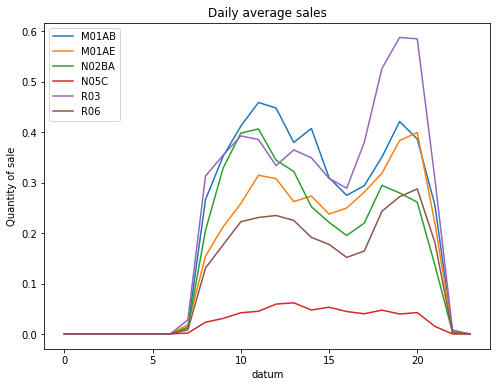

In [ ]:
dfatch=pd.read_csv('./saleshourly.csv')
dfatch['datum']= pd.to_datetime(dfatch['datum']) 

grp1=dfatch.groupby(dfatch.datum.dt.hour)['M01AB'].mean()
grp2=dfatch.groupby(dfatch.datum.dt.hour)['M01AE'].mean()
grp3=dfatch.groupby(dfatch.datum.dt.hour)['N02BA'].mean()
grp6=dfatch.groupby(dfatch.datum.dt.hour)['N05C'].mean()
grp7=dfatch.groupby(dfatch.datum.dt.hour)['R03'].mean()
grp8=dfatch.groupby(dfatch.datum.dt.hour)['R06'].mean()

plt.title('Daily average sales')
plt.xlabel('Time of day')
plt.ylabel('Quantity of sale')

grp1.plot(figsize=(8,6))
grp2.plot(figsize=(8,6))
grp3.plot(figsize=(8,6))
grp6.plot(figsize=(8,6))
grp7.plot(figsize=(8,6))
grp8.plot(figsize=(8,6))

plt.legend(['M01AB', 'M01AE', 'N02BA', 'N05C', 'R03', 'R06'], loc='upper left')

plt.show()

Farklı ilgi kategorileri için haftalık satış grafiği aşağıda gösterilmiştir. N02BE ve N05B çizelgeleri, benzer eğilimleri gösterse de, diğer çizimleri daha az okunabilir hale getiren daha büyük ölçek nedeniyle gizlenmiştir.

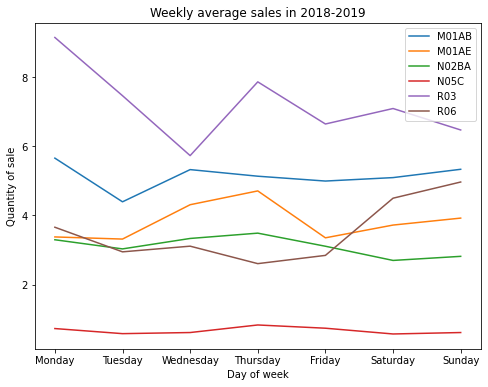

In [ ]:
dfatcw=pd.read_csv('./salesdaily.csv')
dfatcw['datum']= pd.to_datetime(dfatcw['datum'])
days = ['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday', 'Sunday']
plt.rcParams.update({'font.size': 10})

grp1=dfatcw.loc[dfatcw.datum>'2018-01-01'].groupby(dfatch.datum.dt.day_name())['M01AB'].mean().reindex(days)
grp2=dfatcw.loc[dfatcw.datum>'2018-01-01'].groupby(dfatch.datum.dt.day_name())['M01AE'].mean().reindex(days)
grp3=dfatcw.loc[dfatcw.datum>'2018-01-01'].groupby(dfatch.datum.dt.day_name())['N02BA'].mean().reindex(days)
grp6=dfatcw.loc[dfatcw.datum>'2018-01-01'].groupby(dfatch.datum.dt.day_name())['N05C'].mean().reindex(days)
grp7=dfatcw.loc[dfatcw.datum>'2018-01-01'].groupby(dfatch.datum.dt.day_name())['R03'].mean().reindex(days)
grp8=dfatcw.loc[dfatcw.datum>'2018-01-01'].groupby(dfatch.datum.dt.day_name())['R06'].mean().reindex(days)

grp1.plot(figsize=(8,6))
grp2.plot(figsize=(8,6))
grp3.plot(figsize=(8,6))
grp6.plot(figsize=(8,6))
grp7.plot(figsize=(8,6))
grp8.plot(figsize=(8,6))

plt.legend(['M01AB', 'M01AE', 'N02BA', 'N05C', 'R03', 'R06'], loc='upper right')
plt.title('Weekly average sales in 2018-2019')
plt.xlabel('Day of week')
plt.ylabel('Quantity of sale')

plt.show()

Zaman serisi tahmini

In [ ]:
resultsRolling={'M01AB':[0.0,0.0,0.0,0.0,0.0,0.0],
     'M01AE':[0.0,0.0,0.0,0.0,0.0,0.0],
     'N02BA':[0.0,0.0,0.0,0.0,0.0,0.0],
     'N02BE':[0.0,0.0,0.0,0.0,0.0,0.0],
     'N05B':[0.0,0.0,0.0,0.0,0.0,0.0],
     'N05C':[0.0,0.0,0.0,0.0,0.0,0.0],
     'R03':[0.0,0.0,0.0,0.0,0.0,0.0],
     'R06':[0.0,0.0,0.0,0.0,0.0,0.0]}
resultsRollingdf = pd.DataFrame(resultsRolling)
resultsRollingdf.index = ['Naive MSE', 'Naive MAPE', 'Seasonal Naive MSE', 'Seasonal Naive MAPE', 
                          'ARIMA MSE', 'ARIMA MAPE',]
resultsLongterm={'M01AB':[0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0],
     'M01AE':[0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0],
     'N02BA':[0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0],
     'N02BE':[0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0],
     'N05B':[0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0],
     'N05C':[0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0],
     'R03':[0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0],
     'R06':[0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0]}
resultsLongtermdf = pd.DataFrame(resultsLongterm)
resultsLongtermdf.index = ['Average MSE', 'Average MAPE', 'ARIMA MSE', 'ARIMA MAPE', 
                           'Vanilla LSTM MSE', 'Vanilla LSTM MAPE', 'Stacked LSTM MSE', 'Stacked LSTM MAPE',
                          'Bidirectional LSTM MSE', 'Bidirectional LSTM MAPE']

Temel tahmin doğruluğu

Bu alt bölümde, Naif yöntemler olmak üzere referans kriterlerin üç özeti sunulmaktadır. İlk olarak, Naif tahmin yapıldı ve sonuçlar sunuldu. İkinci olarak, tahmin için ortalama yöntemi kullanılmıştır. Son olarak mevsimsel olarak bulunan N02BE, R03 ve R06 serileri için mevsimsel Naif tahmin yapılmıştır.

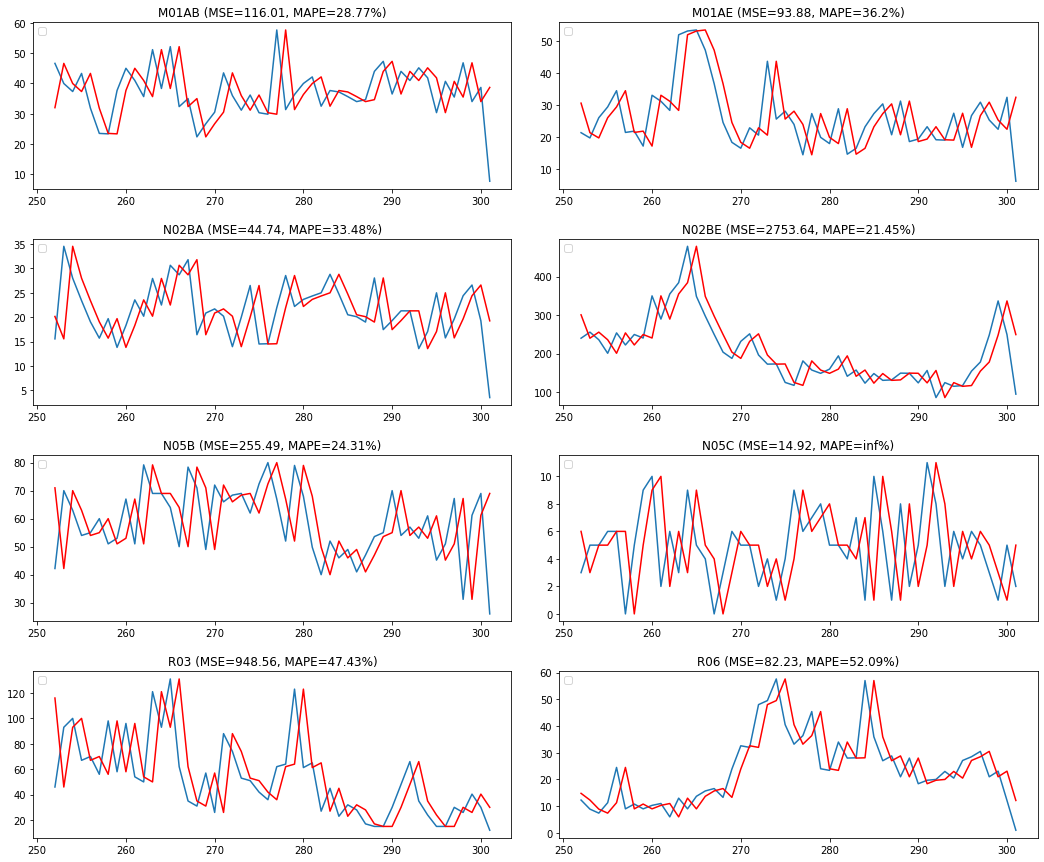

In [ ]:
df=pd.read_csv('./salesweekly.csv')
subplotindex=0
numrows=4
numcols=2
fig, ax = plt.subplots(numrows, numcols, figsize=(18,15))
plt.subplots_adjust(wspace=0.1, hspace=0.3)
for x in ['M01AB','M01AE','N02BA','N02BE','N05B','N05C','R03','R06']:
    rowindex=math.floor(subplotindex/numcols)
    colindex=subplotindex-(rowindex*numcols)
    ds=df[x]
    dataframe = concat([ds.shift(1), ds], axis=1)
    dataframe.columns = ['t+1', 't-1']
    size = len(dataframe)-50
    X=dataframe['t-1']
    Y=dataframe['t+1']
    test, predictions = X[size:len(X)], Y[size:len(Y)]
    error = mean_squared_error(test, predictions)
    perror = mean_absolute_percentage_error(test, predictions)
    resultsRollingdf.loc['Naive MSE',x]=error
    resultsRollingdf.loc['Naive MAPE',x]=perror
    ax[rowindex,colindex].set_title(x+' (MSE=' + str(round(error,2))+', MAPE='+ str(round(perror,2)) +'%)')
    ax[rowindex,colindex].legend(['Real', 'Predicted'], loc='upper left')
    ax[rowindex,colindex].plot(test)
    ax[rowindex,colindex].plot(predictions, color='red')
    subplotindex=subplotindex+1
plt.show()

Ortalama yöntem tahmini

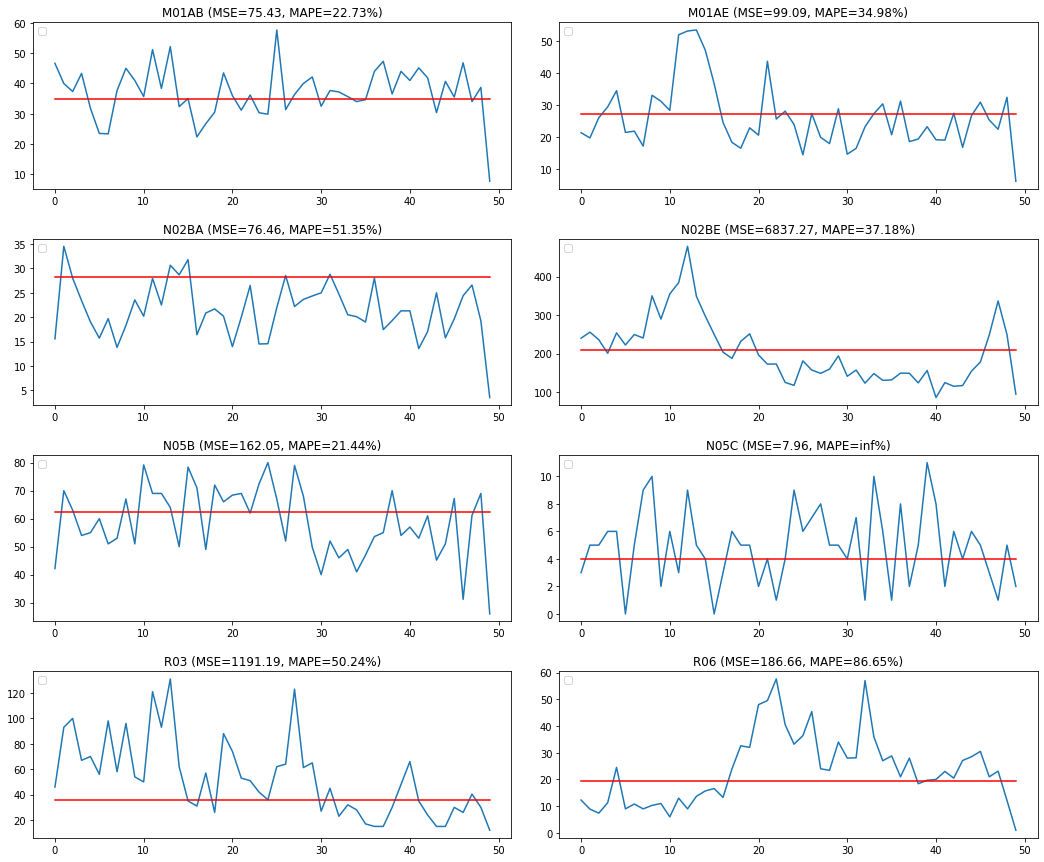

In [ ]:
df=pd.read_csv('./salesweekly.csv')
subplotindex=0
numrows=4
numcols=2
fig, ax = plt.subplots(numrows, numcols, figsize=(18,15))
plt.subplots_adjust(wspace=0.1, hspace=0.3)
for x in ['M01AB','M01AE','N02BA','N02BE','N05B','N05C','R03','R06']:
    rowindex=math.floor(subplotindex/numcols)
    colindex=subplotindex-(rowindex*numcols)
    X=df[x].values
    size = len(X)-50
    test = X[size:len(X)] 
    mean = np.mean(X[0:size])
    predictions = np.full(50,mean)
    error = mean_squared_error(test, predictions)
    perror = mean_absolute_percentage_error(test, predictions)
    resultsLongtermdf.loc['Average MSE',x]=error
    resultsLongtermdf.loc['Average MAPE',x]=perror
    ax[rowindex,colindex].set_title(x+' (MSE=' + str(round(error,2))+', MAPE='+ str(round(perror,2)) +'%)')
    ax[rowindex,colindex].legend(['Real', 'Predicted'], loc='upper left')
    ax[rowindex,colindex].plot(test)
    ax[rowindex,colindex].plot(predictions, color='red')
    subplotindex=subplotindex+1
plt.show()

Mevsimsel Naif tahmin

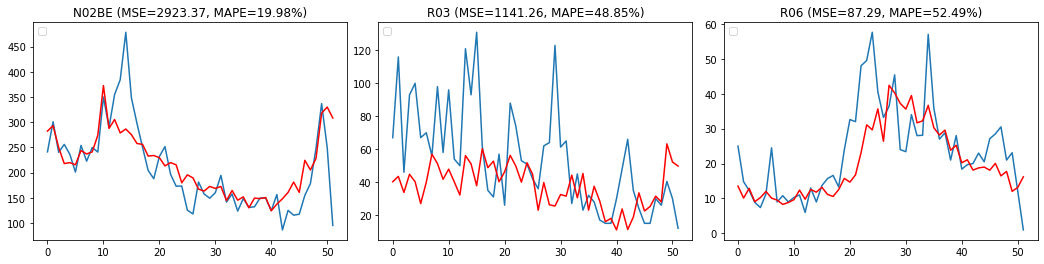

In [ ]:
df=pd.read_csv('./salesweekly.csv')
subplotindex=0
numrows=1
numcols=3
fig, ax = plt.subplots(numrows, numcols, figsize=(18,4))
plt.subplots_adjust(wspace=0.1, hspace=0.3)
for x in ['N02BE','R03','R06']:
    rowindex=math.floor(subplotindex/numcols)
    colindex=subplotindex-(rowindex*numcols)
    X=df[x].values
    size = len(X)-52
    test = X[size:len(X)]
    train = X[0:size]
    predictions=list()
    history = [x for x in train]
    for i in range(len(test)):
        obs=list()
        for y in range(1,5):
            obs.append(train[-(y*52)+i])
        yhat = np.mean(obs)
        predictions.append(yhat)
        history.append(test[i])
    error = mean_squared_error(test, predictions)
    perror = mean_absolute_percentage_error(test, predictions)
    resultsRollingdf.loc['Seasonal Naive MSE',x]=error
    resultsRollingdf.loc['Seasonal Naive MAPE',x]=perror
    ax[colindex].set_title(x+' (MSE=' + str(round(error,2))+', MAPE='+ str(round(perror,2)) +'%)')
    ax[colindex].legend(['Real', 'Predicted'], loc='upper left')
    ax[colindex].plot(test)
    ax[colindex].plot(predictions, color='red')
    subplotindex=subplotindex+1
plt.show() 

ARIMA Tahmini

In [ ]:
!pip uninstall statsmodels -y

In [ ]:
!pip install statsmodels

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


Test verilerine dayalı olarak kısa vadeli (yuvarlanan tahmin) ve uzun vadeli tahmin yapmak için ARIMA yöntemi kullanıldı. Her tahmin yapılmadan önce ARIMA modelinin hiper parametrelerinin (p,d,q) optimize edilmesi işlemi gerçekleştirilmiştir. Ardından, optimal parametre seti ile yuvarlanan tahmin ve uzun vadeli tahmin gerçekleştirilmiştir. Mevsimsel ARIMA (SARIMA) yöntemi, Auto-ARIMA uygulaması kullanılarak test edilmiştir.

ARIMA modeli için parametre seçimi
İlk olarak, başlangıç ​​p ve q parametrelerini belirlemek için arma_order_select_ic yöntemi kullanıldı. Yöntem, birçok ARIMA modeli için Akaike'nin Bilgi Kriterini (AIC) hesaplar ve en iyi konfigürasyonu seçer. AIC'nin bir modelin uygun fark alma (d) sırasını seçmek için iyi bir kılavuz olma eğiliminde olmadığını, sadece p ve q değerlerini seçmek için iyi bir kılavuz olma eğiliminde olduğunu belirtmek önemlidir.

In [ ]:
import statsmodels.api as sm
df=pd.read_csv('./salesweekly.csv')
warnings.filterwarnings("ignore")
for x in ['M01AB','M01AE','N02BA','N02BE', 'N05B','N05C','R03','R06']:
    resDiff = sm.tsa.arma_order_select_ic(df[x], max_ar=5, max_ma=5, ic='aic', trend='c')
    print('ARIMA(p,q,'+x+') =',resDiff['aic_min_order'],'is the best.')

ARIMA(p,q,M01AB) = (3, 3) is the best.
ARIMA(p,q,M01AE) = (2, 0) is the best.
ARIMA(p,q,N02BA) = (3, 3) is the best.
ARIMA(p,q,N02BE) = (2, 2) is the best.
ARIMA(p,q,N05B) = (4, 3) is the best.
ARIMA(p,q,N05C) = (3, 2) is the best.
ARIMA(p,q,R03) = (1, 1) is the best.
ARIMA(p,q,R06) = (2, 2) is the best.


Ancak, bu araştırmada tahmin yöntemlerinin doğruluğunu puanlamak için AIC kullanılmamaktadır. Bunun yerine ortalama kare hatası kullanılır. Bu nedenle, MSE'yi hesaplamak için hiper-parametrelerin farklı kombinasyonlarının kullanıldığı grid arama optimizasyon yöntemi uygulanmış ve daha sonra en az MSE üreten kombinasyon optimal olarak seçilmiştir. Izgara arama optimizasyonu, tahminde her iki yaklaşım için de gerçekleştirilir: yuvarlanan ve uzun vadeli.

Dönen tahmin için ızgara arama optimizasyonu, hiper-parametrelerin aşağıdaki en iyi kombinasyonlarını üretti:

In [ ]:
def evaluate_arima_model(X, arima_order):
    train_size = int(len(X) * 0.66)
    train, test = X[0:train_size], X[train_size:]
    history = [x for x in train]
    predictions = list()
    for t in range(len(test)):
        model = ARIMA(history, order=arima_order)
        model_fit = model.fit(disp=0)
        yhat = model_fit.forecast()[0]
        predictions.append(yhat)
        history.append(test[t])
    error = mean_squared_error(test, predictions)
    return error

def evaluate_models(f, dataset, p_values, d_values, q_values):
    best_score, best_cfg = float("inf"), None
    for p in p_values:
        for d in d_values:
            for q in q_values:
                order = (p,d,q)
                try:
                    mse = evaluate_arima_model(dataset, order)
                    if mse < best_score:
                        best_score, best_cfg = mse, order
                except:
                    continue
    print(f+' - Best ARIMA%s MSE=%.3f' % (best_cfg, best_score))

p_values = range(0, 6)
d_values = range(0, 2)
q_values = range(0, 6)

warnings.filterwarnings("ignore")

df=pd.read_csv('./salesweekly.csv')

for f in ['M01AB','M01AE','N02BA','N02BE','N05B','N05C','R03','R06']:
    evaluate_models(f, df[f].values, p_values, d_values, q_values)

M01AB - Best ARIMANone MSE=inf
M01AE - Best ARIMANone MSE=inf
N02BA - Best ARIMANone MSE=inf
N02BE - Best ARIMANone MSE=inf
N05B - Best ARIMANone MSE=inf
N05C - Best ARIMANone MSE=inf
R03 - Best ARIMANone MSE=inf
R06 - Best ARIMANone MSE=inf


Uzun vadeli tahmin için ızgara arama optimizasyonu, hiper parametrelerin aşağıdaki en iyi kombinasyonlarını üretti:

In [ ]:
def evaluate_arima_model(X, arima_order):
    train_size = int(len(X) - 50)
    train, test = X[0:train_size], X[train_size:]
    model = ARIMA(train, order=arima_order)
    model_fit = model.fit()
    forecast = model_fit.predict(1,len(test))
    error = mean_squared_error(test, forecast)
    return error

def evaluate_models(f, dataset, p_values, d_values, q_values):
    best_score, best_cfg = float("inf"), None
    for p in p_values:
        for d in d_values:
            for q in q_values:
                order = (p,d,q)
                try:
                    mse = evaluate_arima_model(dataset, order)
                    if mse < best_score:
                        best_score, best_cfg = mse, order
                except:
                    continue
    print(f+' - Best ARIMA%s MSE=%.3f' % (best_cfg, best_score))

p_values = range(0, 6)
d_values = range(0, 2)
q_values = range(0, 6)

warnings.filterwarnings("ignore")

for f in ['M01AB','M01AE','N02BA','N02BE','N05B','N05C','R03','R06']:
    evaluate_models(f, df[f].values, p_values, d_values, q_values)

M01AB - Best ARIMA(0, 0, 0) MSE=75.429
M01AE - Best ARIMA(4, 0, 4) MSE=98.438
N02BA - Best ARIMA(0, 0, 0) MSE=76.461
N02BE - Best ARIMA(0, 0, 0) MSE=6837.270
N05B - Best ARIMA(0, 0, 0) MSE=162.051
N05C - Best ARIMA(1, 0, 2) MSE=7.528
R03 - Best ARIMA(0, 0, 0) MSE=1191.187
R06 - Best ARIMA(5, 0, 4) MSE=161.670


ARIMA modeli ile yuvarlama tahmini

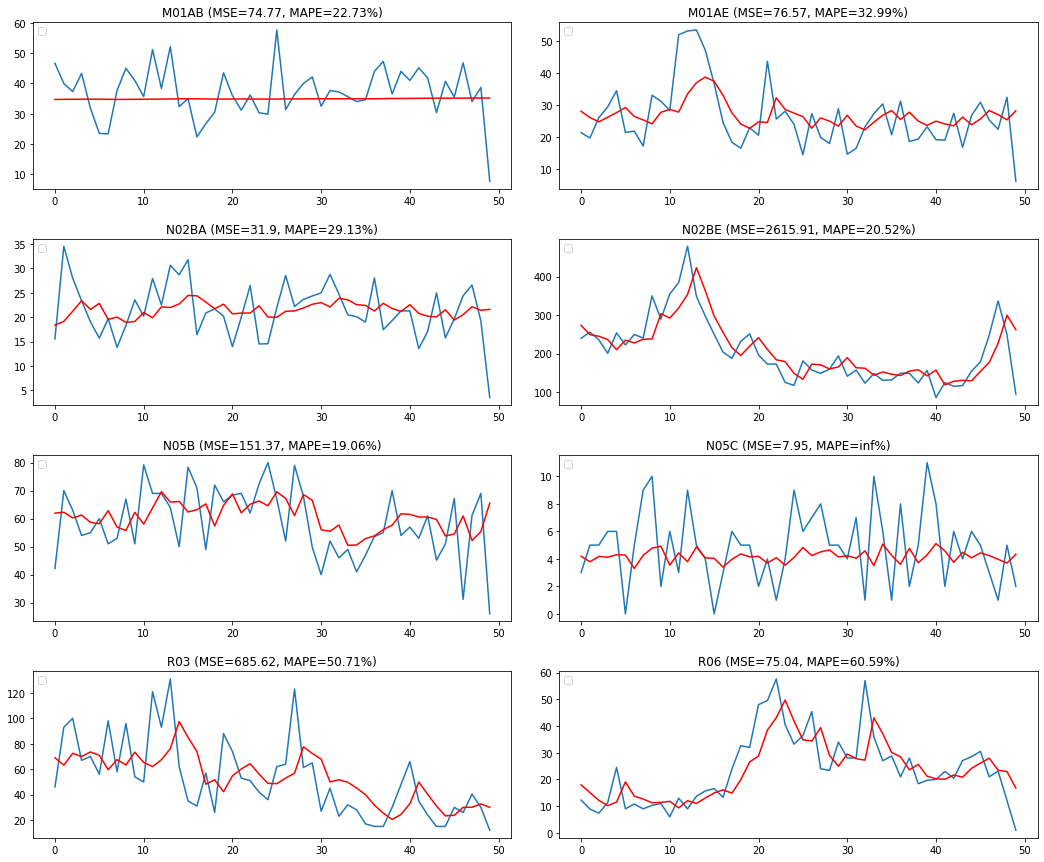

In [ ]:
df=pd.read_csv('./salesweekly.csv')

M01AB= {'series':'M01AB','p':0,'d':0,'q':0}
M01AE= {'series':'M01AE','p':2,'d':0,'q':0}
N02BA= {'series':'N02BA','p':5,'d':1,'q':1}
N02BE= {'series':'N02BE','p':2,'d':0,'q':0}
N05B= {'series':'N05B','p':0,'d':0,'q':5}
N05C= {'series':'N05C','p':0,'d':0,'q':1}
R03= {'series':'R03','p':5,'d':1,'q':1}
R06= {'series':'R06','p':1,'d':0,'q':1}

subplotindex=0
numrows=4
numcols=2
fig, ax = plt.subplots(numrows, numcols, figsize=(18,15))
plt.subplots_adjust(wspace=0.1, hspace=0.3)

warnings.filterwarnings("ignore")

for x in [M01AB,M01AE,N02BA,N02BE,N05B,N05C,R03,R06]:
    rowindex=math.floor(subplotindex/numcols)
    colindex=subplotindex-(rowindex*numcols)
    X = df[x['series']].values
    size = len(X)-50
    train, test = X[0:size], X[size:len(X)]
    history = [x for x in train]
    predictions = list()
    for t in range(len(test)):
        model = ARIMA(history, order=(x['p'],x['d'],x['q']))
        model_fit = model.fit()
        output = model_fit.forecast()
        yhat = output[0]
        predictions.append(yhat)
        obs = test[t]
        history.append(obs)
    error = mean_squared_error(test, predictions)
    perror = mean_absolute_percentage_error(test, predictions)
    resultsRollingdf.loc['ARIMA MSE',x['series']]=error
    resultsRollingdf.loc['ARIMA MAPE',x['series']]=perror
    ax[rowindex,colindex].set_title(x['series']+' (MSE=' + str(round(error,2))+', MAPE='+ str(round(perror,2)) +'%)')
    ax[rowindex,colindex].legend(['Real', 'Predicted'], loc='upper left')
    ax[rowindex,colindex].plot(test)
    ax[rowindex,colindex].plot(predictions, color='red')
    subplotindex=subplotindex+1
plt.show()

ARIMA modeli ile uzun vadeli tahmin

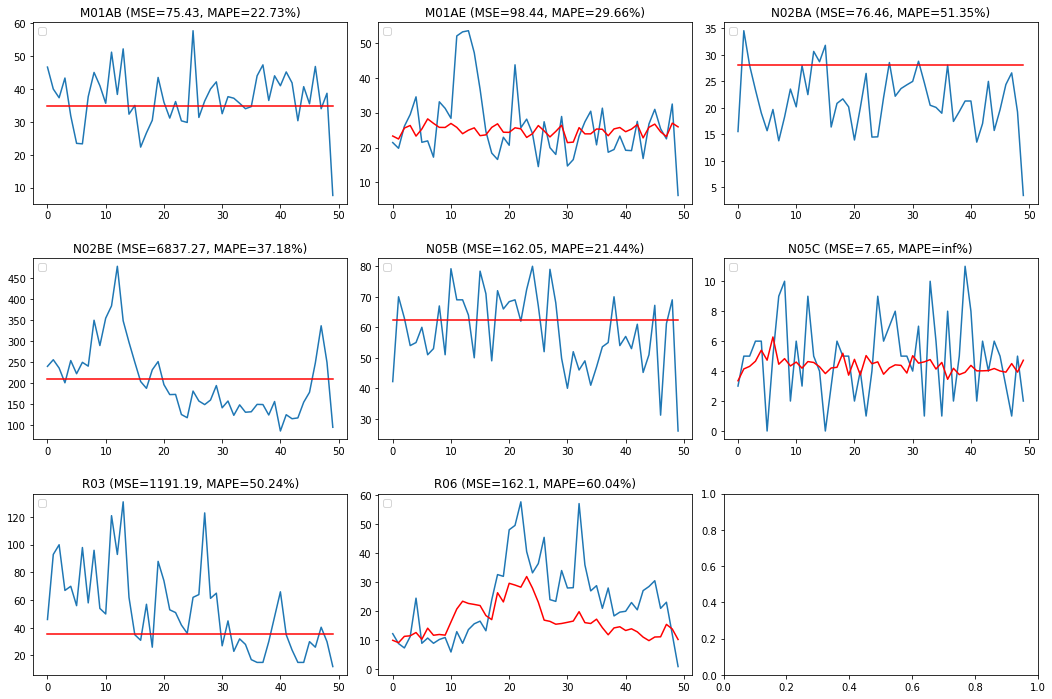

In [ ]:
df=pd.read_csv('./salesweekly.csv')

M01AB= {'series':'M01AB','p':0,'d':0,'q':0}
M01AE= {'series':'M01AE','p':4,'d':0,'q':4}
N02BA= {'series':'N02BA','p':0,'d':0,'q':0}
N02BE= {'series':'N02BE','p':0,'d':0,'q':0}
N05B= {'series':'N05B','p':0,'d':0,'q':0}
N05C= {'series':'N05C','p':2,'d':0,'q':2}
R03= {'series':'R03','p':0,'d':0,'q':0}
R06= {'series':'R06','p':2,'d':0,'q':2}

subplotindex=0
numrows=3
numcols=3
fig, ax = plt.subplots(numrows, numcols, figsize=(18,12))
plt.subplots_adjust(wspace=0.1, hspace=0.3)

warnings.filterwarnings("ignore")

for x in [M01AB,M01AE,N02BA,N02BE,N05B,N05C,R03,R06]:
    rowindex=math.floor(subplotindex/numcols)
    colindex=subplotindex-(rowindex*numcols)
    X = df[x['series']].values
    size = int(len(X) - 50)
    train, test = X[0:size], X[size:len(X)]
    model = ARIMA(train, order=(x['p'],x['d'],x['q']))
    model_fit = model.fit()
    forecast = model_fit.predict(1,len(test))
    error = mean_squared_error(test, forecast)
    perror = mean_absolute_percentage_error(test, forecast)
    resultsLongtermdf.loc['ARIMA MSE',x['series']]=error
    resultsLongtermdf.loc['ARIMA MAPE',x['series']]=perror
    ax[rowindex,colindex].set_title(x['series']+' (MSE=' + str(round(error,2))+', MAPE='+ str(round(perror,2)) +'%)')
    ax[rowindex,colindex].legend(['Real', 'Predicted'], loc='upper left')
    ax[rowindex,colindex].plot(test)
    ax[rowindex,colindex].plot(forecast, color='red')
    subplotindex=subplotindex+1
plt.show()

LSTM ile tahmin

In [ ]:
seed_value= 0
import os
os.environ['PYTHONHASHSEED']=str(seed_value)
import random
random.seed(seed_value)
import numpy as np
np.random.seed(seed_value)
import tensorflow as tf
tf.random.set_seed(seed_value)

session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
sess = tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(), config=session_conf)
tf.compat.v1.keras.backend.set_session(sess)

LSTM ile tahmin için gerekli bileşenler daha sonra içe aktarılır. Göz önünde bulundurulması gereken önceki adımların sayısı gibi sabitler dahil, denetimli makine öğrenimi sorunu için zaman serisi verilerini verilere dönüştürmek için işlev split_sequence sağlanır.

In [ ]:
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
from keras.layers import Bidirectional
from sklearn.preprocessing import MinMaxScaler

def split_sequence(sequence, n_steps):
    X, y = list(), list()
    for i in range(len(sequence)):
        end_ix = i + n_steps
        if end_ix > len(sequence)-1:
            break
        seq_x, seq_y = sequence[i:end_ix], sequence[end_ix]
        X.append(seq_x)
        y.append(seq_y)
    return array(X), array(y)

size = int(len(df) - 50)
n_steps=5
n_features = 1

Vanilla LSTM modeli ile uzun vadeli tahmin

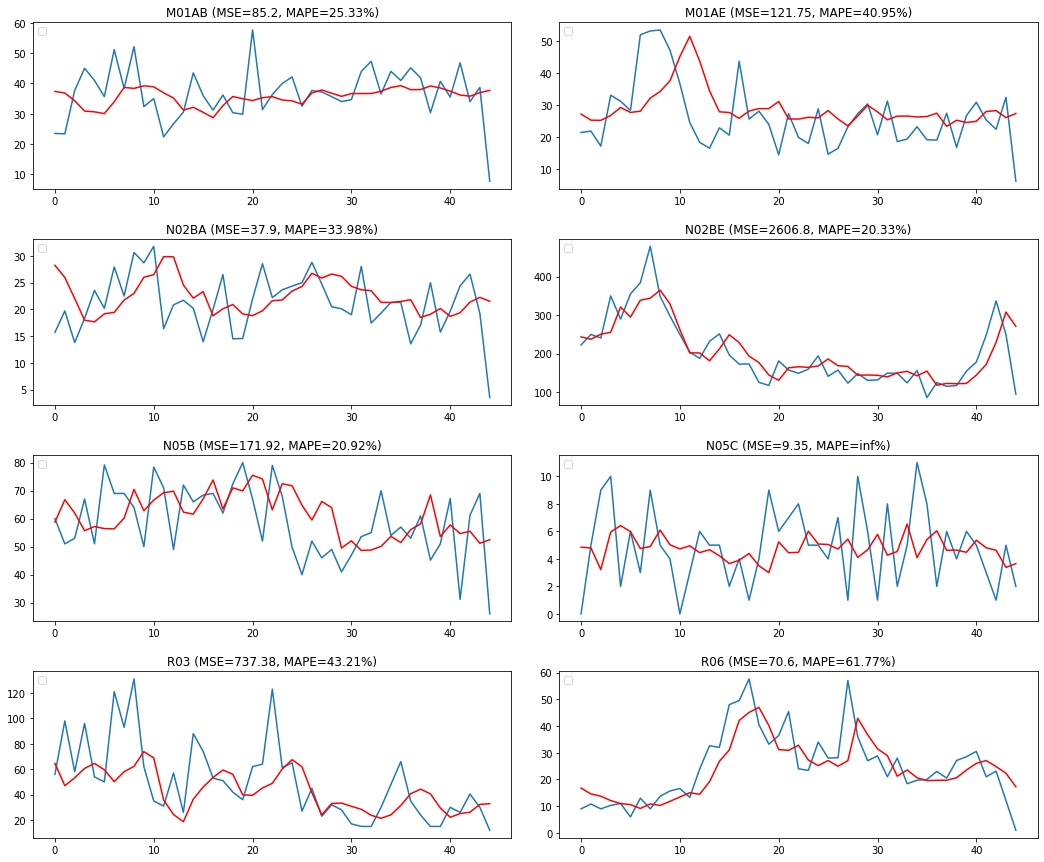

In [ ]:
df=pd.read_csv('./salesweekly.csv')

subplotindex=0
numrows=4
numcols=2
fig, ax = plt.subplots(numrows, numcols, figsize=(18,15))
plt.subplots_adjust(wspace=0.1, hspace=0.3)

warnings.filterwarnings("ignore")

r=['M01AB','M01AE','N02BA','N02BE','N05B','N05C','R03','R06']
for x in r:
    rowindex=math.floor(subplotindex/numcols)
    colindex=subplotindex-(rowindex*numcols)
    X=df[x].values
    scaler = MinMaxScaler(feature_range = (0, 1))
    X=scaler.fit_transform(X.reshape(-1, 1))
    X_train,y_train=split_sequence(X[0:size], n_steps)
    X_test,y_test=split_sequence(X[size:len(df)], n_steps)
    X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], n_features))
    model = Sequential()
    model.add(LSTM(100, activation='relu', input_shape=(n_steps, n_features)))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mse')
    model.fit(X_train, y_train, epochs=400, verbose=0)
    X_test = X_test.reshape((len(X_test), n_steps, n_features))
    predictions = model.predict(X_test, verbose=0)
    y_test=scaler.inverse_transform(y_test)
    predictions = scaler.inverse_transform(predictions)
    error = mean_squared_error(y_test, predictions)
    perror = mean_absolute_percentage_error(y_test, predictions)
    resultsLongtermdf.loc['Vanilla LSTM MSE',x]=error
    resultsLongtermdf.loc['Vanilla LSTM MAPE',x]=perror
    ax[rowindex,colindex].set_title(x+' (MSE=' + str(round(error,2))+', MAPE='+ str(round(perror,2)) +'%)')
    ax[rowindex,colindex].legend(['Real', 'Predicted'], loc='upper left')
    ax[rowindex,colindex].plot(y_test)
    ax[rowindex,colindex].plot(predictions, color='red')
    subplotindex=subplotindex+1
plt.show()

Stacked(Yığılmış) LSTM modeliyle uzun vadeli tahmin

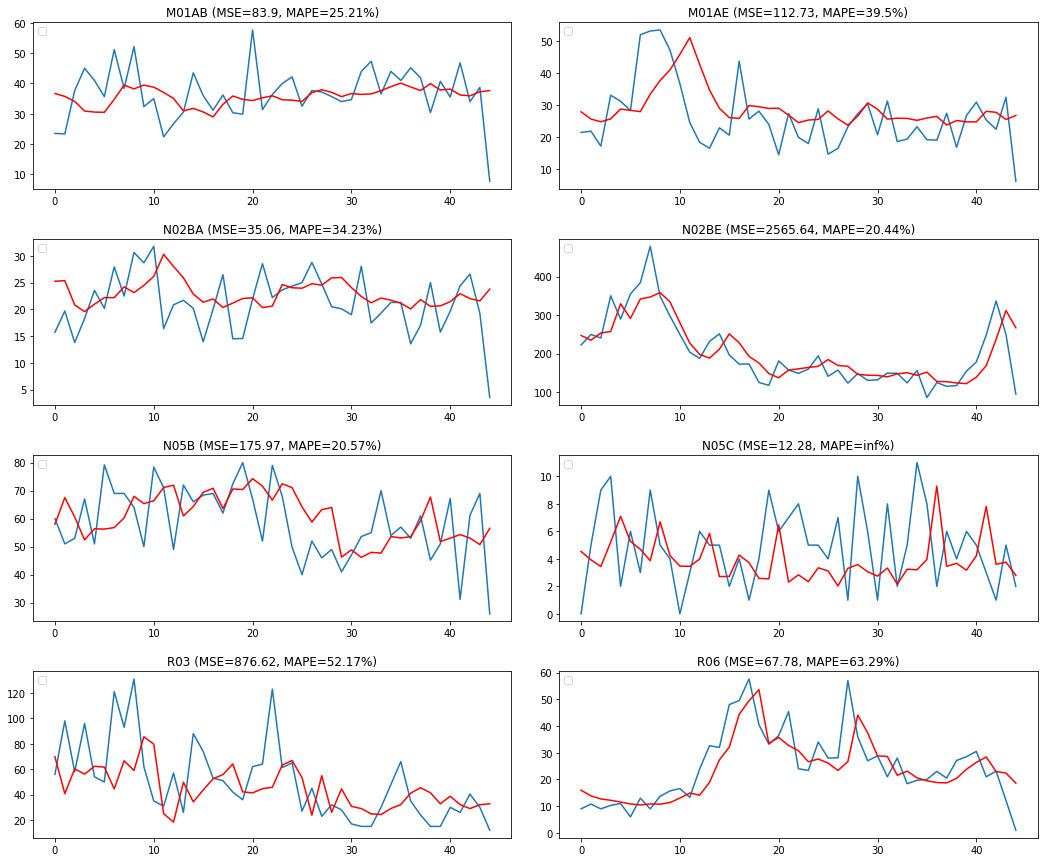

In [ ]:
df=pd.read_csv('./salesweekly.csv')

subplotindex=0
numrows=4
numcols=2
fig, ax = plt.subplots(numrows, numcols, figsize=(18,15))
plt.subplots_adjust(wspace=0.1, hspace=0.3)

warnings.filterwarnings("ignore")

r=['M01AB','M01AE','N02BA','N02BE','N05B','N05C','R03','R06']
for x in r:
    rowindex=math.floor(subplotindex/numcols)
    colindex=subplotindex-(rowindex*numcols)
    X=df[x].values
    scaler = MinMaxScaler(feature_range = (0, 1))
    X=scaler.fit_transform(X.reshape(-1, 1))
    X_train,y_train=split_sequence(X[0:size], n_steps)
    X_test,y_test=split_sequence(X[size:len(df)], n_steps)
    X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], n_features))
    
    model = Sequential()
    model.add(LSTM(100, activation='relu', return_sequences=True, input_shape=(n_steps, n_features)))
    model.add(LSTM(100, activation='relu'))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mse')
    model.fit(X_train, y_train, epochs=400, verbose=0)
    
    X_test = X_test.reshape((len(X_test), n_steps, n_features))
    predictions = model.predict(X_test, verbose=0)
    y_test=scaler.inverse_transform(y_test)
    predictions = scaler.inverse_transform(predictions)
    error = mean_squared_error(y_test, predictions)
    perror = mean_absolute_percentage_error(y_test, predictions)
    resultsLongtermdf.loc['Stacked LSTM MSE',x]=error
    resultsLongtermdf.loc['Stacked LSTM MAPE',x]=perror
    ax[rowindex,colindex].set_title(x+' (MSE=' + str(round(error,2))+', MAPE='+ str(round(perror,2)) +'%)')
    ax[rowindex,colindex].legend(['Real', 'Predicted'], loc='upper left')
    ax[rowindex,colindex].plot(y_test)
    ax[rowindex,colindex].plot(predictions, color='red')
    subplotindex=subplotindex+1
plt.show()

Bidirectional(Çift Yönlü) LSTM modeli ile uzun vadeli tahmin

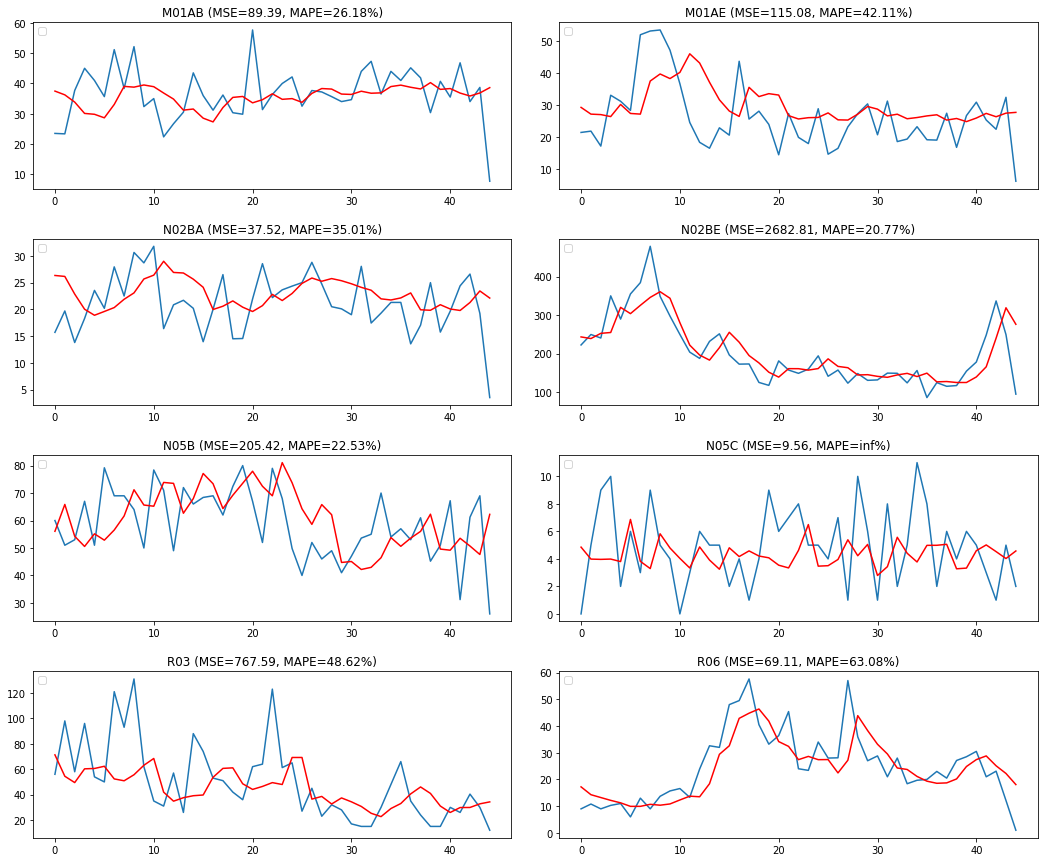

In [ ]:
df=pd.read_csv('./salesweekly.csv')

subplotindex=0
numrows=4
numcols=2
fig, ax = plt.subplots(numrows, numcols, figsize=(18,15))
plt.subplots_adjust(wspace=0.1, hspace=0.3)

warnings.filterwarnings("ignore")

r=['M01AB','M01AE','N02BA','N02BE','N05B','N05C','R03','R06']
for x in r:
    rowindex=math.floor(subplotindex/numcols)
    colindex=subplotindex-(rowindex*numcols)
    X=df[x].values
    scaler = MinMaxScaler(feature_range = (0, 1))
    X=scaler.fit_transform(X.reshape(-1, 1))
    X_train,y_train=split_sequence(X[0:size], n_steps)
    X_test,y_test=split_sequence(X[size:len(df)], n_steps)
    X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], n_features))

    model = Sequential()
    model.add(Bidirectional(LSTM(50, activation='relu'), input_shape=(n_steps, n_features)))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mse')
    model.fit(X_train, y_train, epochs=400, verbose=0)

    X_test = X_test.reshape((len(X_test), n_steps, n_features))
    predictions = model.predict(X_test, verbose=0)
    y_test=scaler.inverse_transform(y_test)
    predictions = scaler.inverse_transform(predictions)
    error = mean_squared_error(y_test, predictions)
    perror = mean_absolute_percentage_error(y_test, predictions)
    resultsLongtermdf.loc['Bidirectional LSTM MSE',x]=error
    resultsLongtermdf.loc['Bidirectional LSTM MAPE',x]=perror
    ax[rowindex,colindex].set_title(x+' (MSE=' + str(round(error,2))+', MAPE='+ str(round(perror,2)) +'%)')
    ax[rowindex,colindex].legend(['Real', 'Predicted'], loc='upper left')
    ax[rowindex,colindex].plot(y_test)
    ax[rowindex,colindex].plot(predictions, color='red')
    subplotindex=subplotindex+1
plt.show()

Sonuç

Değişken tahmin için ARIMA yöntemi daha iyi performans gösterir ve kısa vadeli satış tahmini için en iyi aday olarak kabul edilir.

In [ ]:
from IPython.display import display, HTML
display(HTML(resultsRollingdf.to_html()))

,M01AB,M01AE,N02BA,N02BE,N05B,N05C,R03,R06
Naive MSE,116.014866,93.875126,44.741150,2753.643864,255.485600,14.920000,948.560347,82.228700
Naive MAPE,28.765667,36.202952,33.475848,21.451644,24.308687,inf,47.432638,52.094536
Seasonal Naive MSE,0.000000,0.000000,0.000000,2923.370345,0.000000,0.000000,1141.258975,87.288057
Seasonal Naive MAPE,0.000000,0.000000,0.000000,19.976880,0.000000,0.000000,48.845563,52.491895
ARIMA MSE,74.768467,76.572677,31.898614,2615.907156,151.372279,7.949817,685.618645,75.038189
ARIMA MAPE,22.730366,32.989440,29.131300,20.524169,19.063637,inf,50.709759,60.593717


Uzun vadeli tahmin için, LSTM modelleri, mevsimsellik içeren zaman serilerindeki kıyaslamalardan önemli ölçüde daha iyi performans göstermiştir. Her durumda, optimizasyon olmadan bile, LSTM modelleri rekabetçi performans elde etmiştir.

In [ ]:
from IPython.display import display, HTML
display(HTML(resultsLongtermdf.to_html()))

,M01AB,M01AE,N02BA,N02BE,N05B,N05C,R03,R06
Average MSE,75.428945,99.086133,76.460997,6837.269559,162.050944,7.961872,1191.186483,186.661004
Average MAPE,22.727171,34.980731,51.351070,37.175660,21.443035,inf,50.243843,86.645469
ARIMA MSE,75.428967,98.438373,76.460923,6837.269519,162.050908,7.654225,1191.186637,162.096952
ARIMA MAPE,22.727172,29.661375,51.351045,37.175659,21.443032,inf,50.243840,60.041986
Vanilla LSTM MSE,85.203251,121.752221,37.902918,2606.801266,171.919521,9.346708,737.380196,70.597742
Vanilla LSTM MAPE,25.332773,40.953615,33.980854,20.329117,20.917260,inf,43.213963,61.766697
Stacked LSTM MSE,83.902987,112.729543,35.063190,2565.640069,175.974465,12.277270,876.619120,67.779720
Stacked LSTM MAPE,25.211372,39.497995,34.231356,20.439984,20.567806,inf,52.169424,63.292667
Bidirectional LSTM MSE,89.385835,115.079302,37.516624,2682.806056,205.420255,9.558557,767.590622,69.112346
Bidirectional LSTM MAPE,26.176887,42.113942,35.014334,20.766949,22.526614,inf,48.622517,63.081027
